In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [32]:
import scipy
from scipy.stats import norm

In [33]:
stock='AXISBANK.NS'
data = yf.download(stock,'2005-01-01','2023-05-05')

[*********************100%***********************]  1 of 1 completed


In [34]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,37.000000,38.200001,37.000000,38.040001,32.853134,1421010
2005-01-04,38.220001,38.400002,37.400002,37.939999,32.766777,1115825
2005-01-05,37.990002,37.990002,35.509998,36.849998,31.825399,1163085
2005-01-06,36.820000,38.000000,35.400002,37.029999,31.980867,1192610
2005-01-07,36.130001,38.380001,36.130001,38.020000,32.835869,1530260
...,...,...,...,...,...,...
2023-04-27,888.000000,890.000000,877.500000,881.400024,879.590454,15992383
2023-04-28,885.099976,890.049988,853.650024,860.000000,858.234375,23004117
2023-05-02,870.000000,876.400024,864.250000,870.650024,868.862549,12947953


In [35]:
# data = data[:4000]

In [36]:
returns = np.diff(data['Adj Close'])
returns=-returns

In [37]:
data.shape,returns.shape

((4525, 6), (4524,))

In [38]:
returns.shape

(4524,)

In [39]:
np.sum(returns)

-831.3190460205078

In [40]:
data['Adj Close']

Date
2005-01-03     32.853134
2005-01-04     32.766777
2005-01-05     31.825399
2005-01-06     31.980867
2005-01-07     32.835869
                 ...    
2023-04-27    879.590454
2023-04-28    858.234375
2023-05-02    868.862549
2023-05-03    858.084717
2023-05-04    864.172180
Name: Adj Close, Length: 4525, dtype: float64

In [41]:
mean = np.mean(returns)
std_dev = np.std(returns)
mean,std_dev

(-0.18375752564555875, 8.991496068118296)

In [42]:
pip install KDEpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.7/552.7 kB 16.7 MB/s eta 0:00:00


In [43]:
import KDEpy

In [44]:
np.array(returns)

array([  0.08635712,   0.94137764,  -0.15546799, ..., -10.62817383,
        10.77783203,  -6.08746338])

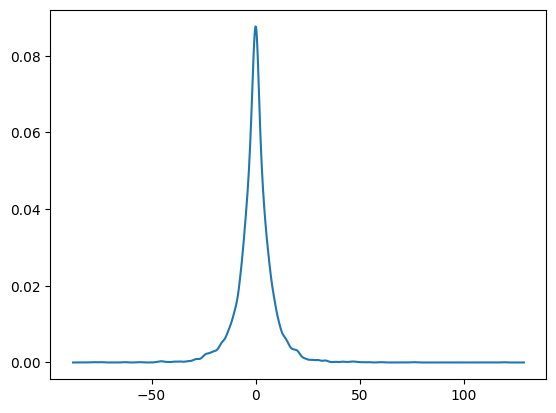

In [45]:
from KDEpy import FFTKDE
import matplotlib.pyplot as plt
x, y = FFTKDE(kernel="gaussian",bw = "silverman").fit(np.array(returns)).evaluate()
plt.plot(x, y)



In [46]:
np.array(data['Adj Close'])

array([ 32.85313416,  32.76677704,  31.8253994 , ..., 868.86254883,
       858.0847168 , 864.17218018])

In [47]:
y


array([2.22044605e-16, 2.22044605e-16, 2.22044605e-16, ...,
       2.22044605e-16, 2.22044605e-16, 2.22044605e-16])

In [48]:
np.sum(y)

4.7218572358956825

In [49]:
np.sort(np.array(returns))

array([-77.87475586, -74.39697266, -63.17364502, ...,  59.9850769 ,
        75.82830811, 119.07342529])

In [50]:
import torch
import torch.nn as nn


In [51]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, predictions, targets):
        errors = targets - predictions
        quantile_loss = torch.max((self.quantile - 1) * errors, self.quantile * errors)
        return quantile_loss.mean()

In [52]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size,dtype=torch.float64)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size,dtype=torch.float64)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [53]:
network = NeuralNetwork(1,5,1)
quantile_loss = QuantileLoss(0.95)

In [54]:
optimizer = torch.optim.SGD(network.parameters(),lr=0.001)
input = np.array(data['Adj Close'])
input=input[0:-1]
input=torch.from_numpy(input)
input= torch.unsqueeze(input, dim=1)
returns=torch.from_numpy(returns)
returns=torch.unsqueeze(returns,dim=1)

In [55]:
for epoch in range(100000):
    outputs = network(input)
    loss = quantile_loss(outputs, returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000== 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1000, Loss: 0.9235333843478899
Epoch: 2000, Loss: 0.9228377156577435
Epoch: 3000, Loss: 0.9222505675409902
Epoch: 4000, Loss: 0.9216707817154103
Epoch: 5000, Loss: 0.9211080481104059
Epoch: 6000, Loss: 0.9205453854196867
Epoch: 7000, Loss: 0.9199750651275949
Epoch: 8000, Loss: 0.9193968189125721
Epoch: 9000, Loss: 0.9188107407210165
Epoch: 10000, Loss: 0.9182324087311713
Epoch: 11000, Loss: 0.9176439038350753
Epoch: 12000, Loss: 0.9170614053128571
Epoch: 13000, Loss: 0.9165049054135449
Epoch: 14000, Loss: 0.9159559689392918
Epoch: 15000, Loss: 0.9154246338798865
Epoch: 16000, Loss: 0.9148909437558556
Epoch: 17000, Loss: 0.9143635045048731
Epoch: 18000, Loss: 0.9138450486112174
Epoch: 19000, Loss: 0.9133336377592625
Epoch: 20000, Loss: 0.9128276831622525
Epoch: 21000, Loss: 0.912342134305914
Epoch: 22000, Loss: 0.9118645312361184
Epoch: 23000, Loss: 0.9114094203144395
Epoch: 24000, Loss: 0.9109586494958296
Epoch: 25000, Loss: 0.9105042903920573
Epoch: 26000, Loss: 0.9100772406156

In [56]:
outputs=network(input[4071:])
compvalue=returns[4071:]
ans=outputs.detach().numpy()
given=compvalue.detach().numpy()
compvalue.shape

torch.Size([453, 1])

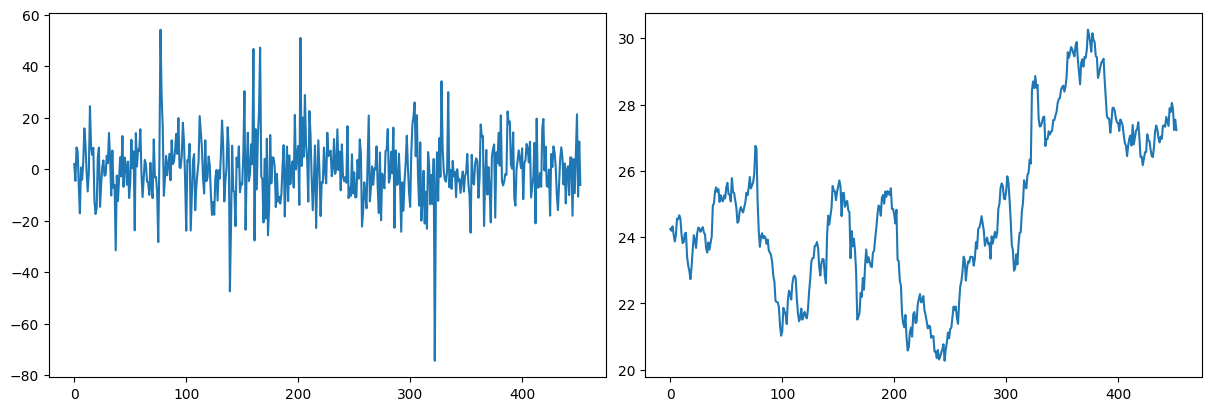

In [57]:
fig,(ax1,ax2)=plt.subplots(1,2,constrained_layout=True,figsize=(12,4))
ax1.plot(returns[4071:])
ax2.plot(ans)

In [58]:
error=given - ans
error


array([[ -22.25879187],
       [ -28.72641781],
       [ -15.85727118],
       [ -17.05114766],
       [ -30.09545002],
       [ -41.14123469],
       [ -23.86118382],
       [ -28.62341525],
       [ -21.6697542 ],
       [  -8.67743611],
       [ -14.68334704],
       [ -24.81707239],
       [ -32.46927717],
       [ -25.00224159],
       [   0.38006375],
       [ -14.63725713],
       [ -17.51612548],
       [ -14.65901005],
       [ -34.93898036],
       [ -40.48197627],
       [ -38.7552722 ],
       [ -19.57432602],
       [ -15.50561907],
       [ -38.27366589],
       [ -30.13684575],
       [ -23.53970384],
       [ -20.82731327],
       [ -26.70397558],
       [ -26.33083443],
       [ -19.06916274],
       [ -21.80375487],
       [  -9.97650166],
       [ -19.52298131],
       [ -33.74915171],
       [ -16.56446106],
       [ -30.8966732 ],
       [ -29.86676819],
       [ -55.55392985],
       [ -27.39257516],
       [ -37.37951798],
       [ -29.17615104],
       [ -20.818

In [59]:
loss=0.0
for i in range(error.shape[0]):
  if(error[i]>0):
    loss=loss+0.95*error[i]
  else:
    loss=loss+(0.05)*(-1)*error[i]
loss=loss/error.shape[0]
loss

array([1.5304881])